# Librerías

In [ ]:
# Pytorch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, utils as vutils
import math, numpy as np, random, os
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F


# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Pandas
import pandas as pd

# Para mostrar el progreso del entrenamiento
from tqdm import tqdm

# Solo para dibujar el grafo de la red
from graphviz import Digraph

# Solo para las animaciones
from IPython.display import Image, HTML, display

In [ ]:
# Semilla aleatoria
seed = 42

# Fijamos la semilla para Pytorch y Numpy
torch.manual_seed(seed)
np.random.seed(seed)

# Si lo desean, pueden "acelerar" la velocidad de entrenamiento de sus redes neuronales
# al utilizar la GPU de sus computadores (o cambiando el Runtime Type en Colab a uno con GPU)
# Si esto les presenta errores extraños ligados a "CUDA", les recomiendo settear esta variable
# como "cpu" (todo el notebook corre sin necesidad de usar GPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Descargamos el Dataset y extraemos las Pizzas
- Cambiamos ToTensor + Normalize a 3 canales (RGB) en lugar de 1
- Pasamos las imagenes del dataset de 512 RGB a 128 para no sobrecargar
- Bajamos batch_size porque ahora las imágenes son mucho más grandes

100%|██████████| 5.00G/5.00G [03:42<00:00, 22.5MB/s]


Ejemplo de clases: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']
Índice de 'pizza': 76


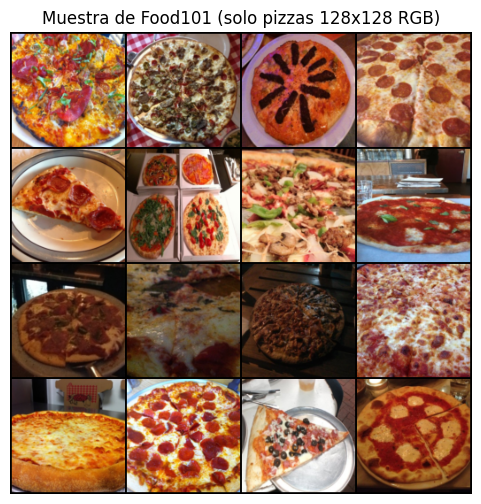

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from pathlib import Path

# Dataset: Food101, solo pizzas, 128x128 RGB ====
data_root = Path("./data_food")

transform = transforms.Compose([
    transforms.Resize((128, 128)),                # redimensionar a 128x128
    transforms.ToTensor(),                        # pasar a tensor [0,1]
    transforms.Normalize(                         # normalizar a [-1,1] por canal
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)
    )
])

# Cargar split de entrenamiento de Food101
food_train = datasets.Food101(
    root=data_root,
    split="train",
    transform=transform,
    download=True
)

# Ver nombres de clases (solo para chequear)
print("Ejemplo de clases:", food_train.classes[:10])

# Buscar el índice de la clase "pizza"
pizza_idx = food_train.classes.index("pizza")
print("Índice de 'pizza':", pizza_idx)

# Quedarnos solo con las imágenes etiquetadas como "pizza"
indices_pizza = [i for i, y in enumerate(food_train._labels) if y == pizza_idx]

# (Opcional) limitar el número de pizzas para que entrenar no sea eterno
# p.ej. usar solo 5000 pizzas:
indices_pizza = indices_pizza[:5000]

pizzas = Subset(food_train, indices_pizza)

batch_size = 16  # mucho más pequeño que 128 porque ahora son 128x128x3
dataloader = DataLoader(
    pizzas,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# Ver unas pizzas para comprobar que todo ok
batch = next(iter(dataloader))[0][:16]  # 16 imágenes
from torchvision import utils as vutils
grid = vutils.make_grid(batch, nrow=4, normalize=True, value_range=(-1, 1))
plt.figure(figsize=(6, 6)); plt.axis("off")
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.title("Muestra de Food101 (solo pizzas 128x128 RGB)")
plt.show()

# Formulas, parametros y herramientas para los tensores

In [ ]:
# Hiperparámetros de difusión (DDPM)
T = 1000                                                                        # pasos de difusión (subir a 1000 si hay paciencia)
beta_start, beta_end = 1e-4, 2e-2
betas = torch.linspace(beta_start, beta_end, T, dtype=torch.float32).to(device) # cuanto ruido nuevo se agrega en cada paso. crece linealmente

alphas = 1.0 - betas                                                 # cuanto se "conserva” de la señal previa en cada paso // fracción de señal que sobrevive
alphas_cumprod = torch.cumprod(alphas, dim=0)                        # pitatoria de los alphas hasta cad tiempo (tensor tambien) // cuánta señal original queda después de t pasos
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)   # Ajuste para casos borde ¿? // agrega algunos 1.0 al tensor en no se cual posicion pa poder operar algunas cosas

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)                  # raiz del tensor alpha acumulado
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)  # raiz del tensor beta acumulado ¿?
sqrt_recip_alphas = torch.sqrt(1.0/alphas)                        # raiz del inverso de alpha acumulado

posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)   # \tilde{β}_t, varianza de 𝑞(𝑥_{𝑡−1}∣𝑥_𝑡,𝑥_0); para muestrear en el reverse (añadir el ruído correcto)

def extract(a, t, x_shape):
    """
    Extrae a[t] y lo da forma (B,1,1,1) para broadcast.
    t: (B,) int64
    """
    out = a.gather(-1, t).float()
    return out.view(-1, 1, 1, 1).expand(x_shape)

def q_sample(x_start, t, noise=None):
    """
    x_t = sqrt(alphacum[t])*x0 + sqrt(1 - alphacum[t])*ε , ε∼𝑁(0,𝐼) (noise)
    para generar “imagen con ruido de nivel t” sin simular paso a paso
    """
    if noise is None:
        noise = torch.randn_like(x_start)
    return extract(sqrt_alphas_cumprod, t, x_start.shape) * x_start + \
           extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise

# Red ("mini")
Unet a Unet128 modificada

In [ ]:
# Modelo: UNet mini para 128x128
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        # t: (B,) enteros en [0, T-1] -> float
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, dtype=torch.float32, device=device) / half)
        args = t.float().unsqueeze(1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return emb  # (B, dim)

class TimeEmbedding(nn.Module):
    def __init__(self, dim, out_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim, out_dim),
            nn.SiLU(),
            nn.Linear(out_dim, out_dim)
        )
    def forward(self, x):
        return self.mlp(x)

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_ch)
        self.act1  = nn.SiLU()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act2  = nn.SiLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_dim, out_ch))
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.conv1(self.act1(self.norm1(x)))
        # sumar emb de tiempo
        t = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = h + t
        h = self.conv2(self.act2(self.norm2(h)))
        return h + self.res_conv(x)

class UNet128(nn.Module):
    """
    U-Net para imágenes 128x128 RGB, condicionada en el tiempo.
    Estructura: 128 -> 64 -> 32 -> 16 y vuelve.
    """
    def __init__(self, img_ch=3, base_ch=32, time_dim=128):
        super().__init__()

        # Embedding de tiempo (igual idea que antes)
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_dim),
            TimeEmbedding(time_dim, time_dim)
        )

        # ---------- Encoder ----------
        self.in_conv = nn.Conv2d(img_ch, base_ch, 3, padding=1)    # 128x128
        self.rb1 = ResBlock(base_ch, base_ch, time_dim)            # 128x128

        self.down1 = nn.Conv2d(base_ch, base_ch*2, 4, stride=2, padding=1)  # 128 -> 64
        self.rb2 = ResBlock(base_ch*2, base_ch*2, time_dim)                 # 64x64

        self.down2 = nn.Conv2d(base_ch*2, base_ch*4, 4, stride=2, padding=1)  # 64 -> 32
        self.rb3 = ResBlock(base_ch*4, base_ch*4, time_dim)                   # 32x32

        self.down3 = nn.Conv2d(base_ch*4, base_ch*8, 4, stride=2, padding=1)  # 32 -> 16
        self.rb4 = ResBlock(base_ch*8, base_ch*8, time_dim)                   # 16x16

        # ---------- Bottleneck ----------
        self.mid1 = ResBlock(base_ch*8, base_ch*8, time_dim)                  # 16x16

        # ---------- Decoder ----------
        self.up1 = nn.ConvTranspose2d(base_ch*8, base_ch*4, 4, stride=2, padding=1)  # 16 -> 32
        self.rb5 = ResBlock(base_ch*8, base_ch*4, time_dim)  # concat con x3: ch duplica (4+4)

        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 4, stride=2, padding=1)  # 32 -> 64
        self.rb6 = ResBlock(base_ch*4, base_ch*2, time_dim)  # concat con x2

        self.up3 = nn.ConvTranspose2d(base_ch*2, base_ch, 4, stride=2, padding=1)    # 64 -> 128
        self.rb7 = ResBlock(base_ch*2, base_ch, time_dim)   # concat con x1

        self.out_conv = nn.Conv2d(base_ch, img_ch, 1)       # salida: 3 canales (RGB)

    def forward(self, x, t):
        # t: (B,)
        t_emb = self.time_emb(t)  # (B, time_dim)

        # Encoder
        x0 = self.in_conv(x)              # 128x128
        x1 = self.rb1(x0, t_emb)          # 128x128

        x2 = self.down1(x1)               # 64x64
        x2 = self.rb2(x2, t_emb)          # 64x64

        x3 = self.down2(x2)               # 32x32
        x3 = self.rb3(x3, t_emb)          # 32x32

        x4 = self.down3(x3)               # 16x16
        x4 = self.rb4(x4, t_emb)          # 16x16

        # Bottleneck
        m = self.mid1(x4, t_emb)          # 16x16

        # Decoder
        u1 = self.up1(m)                  # 32x32
        u1 = torch.cat([u1, x3], dim=1)   # concat skip
        u1 = self.rb5(u1, t_emb)

        u2 = self.up2(u1)                 # 64x64
        u2 = torch.cat([u2, x2], dim=1)
        u2 = self.rb6(u2, t_emb)

        u3 = self.up3(u2)                 # 128x128
        u3 = torch.cat([u3, x1], dim=1)
        u3 = self.rb7(u3, t_emb)

        out = self.out_conv(u3)
        return out  # predicción del ruido ε en 3 canales

# Entrenamiento

Entrenamiento: Minimizar $𝔼_{t,x_0,ε}$[ $||ε-ε_{θ}(x_{t}, t)||^2$ ]

$𝔼_{t,x_0,ε}$[ $||ε-ε_{θ}(\sqrt{\hat{α}}·x_0+\sqrt{1-\hat{α}}·ε, t)||^2$ ]



Intuitivamente: cada parámetro de la red (los pesos de sus neuronas) es una perilla que se puede girar.\
El objetivo es girarlas en la dirección que baja la pérdida $𝔼_{t,x_0,ε}$

In [ ]:
# Entrenamiento
model = UNet128(img_ch=3, base_ch=32, time_dim=128).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4) # optimizamos con descenso de gradiente ajustado para no sobre dimensionar errores y AdamW de algoritmo

loss_step_hist = []    # loss por iteración
loss_epoch_hist = []   # promedio por época

epochs = 80      # "tandas" de entrenamiento // subir para mejor calidad // [15,50]epochs ==> [30,90]minutos
log_every = 100  # frecuencia de logging
global_step = 0
model.train()    # inicia el entrenamiento

for epoch in range(1, epochs+1):
    running = 0.0
    num_logged = 0
    for i, (x, _) in enumerate(dataloader):
        x = x.to(device)                                     # ya está en [-1,1] por la Normalization
        b = x.size(0)                                        # tamaño del Batch
        t = torch.randint(0, T, (b,), device=device).long()  # elige un t distinto unif para cada muestra, así el denoiser  entrena en todos los niveles
        noise = torch.randn_like(x)                          # ε∼𝑁(0,𝐼) de igual dimension q x
        x_noisy = q_sample(x, t, noise)                      # genera x_t

        pred_noise = model(x_noisy, t)        # prediccion del ruido ê
        loss = F.mse_loss(pred_noise, noise)  # Pérdida MSE entre ruido predicho y real (ε-ê)

        optimizer.zero_grad()  # Pone los gradientes acumulados en cero antes del siguiente paso
        loss.backward()        # Calcula hacia atrás qué debe ajustar // calcula los gradientes de la pérdida con respecto a todos los parámetros del modelo
        optimizer.step()       # actualizar pesos (parámetros del modelo) // Usa los gradientes para actualizar los pesos (con AdamW)

        # logging
        loss_val = loss.item()
        loss_step_hist.append(loss_val)
        running += loss_val  # Acumula running para imprimir promedios cada log_every iteraciones
        num_logged += 1
        global_step += 1
        if (i+1) % log_every == 0:
            print(f"Epoch {epoch} | step {i+1}/{len(dataloader)} | loss {running/log_every:.4f}")
            running = 0.0
            num_logged = 0

    # promedio por época
    start = len(loss_step_hist) - len(dataloader)
    loss_epoch = sum(loss_step_hist[start:]) / len(dataloader)
    loss_epoch_hist.append(loss_epoch)

# Guardar pesos
os.makedirs("ckpts", exist_ok=True)
os.makedirs("ckpts", exist_ok=True)
ckpt_path = "ckpts/ddpm_food101_pizza_128_unet128.pt"
torch.save(model.state_dict(), ckpt_path)
print(f"Modelo guardado en {ckpt_path}")

Modelo guardado en ckpts/ddpm_food101_pizza_128_unet128.pt


# Denosising

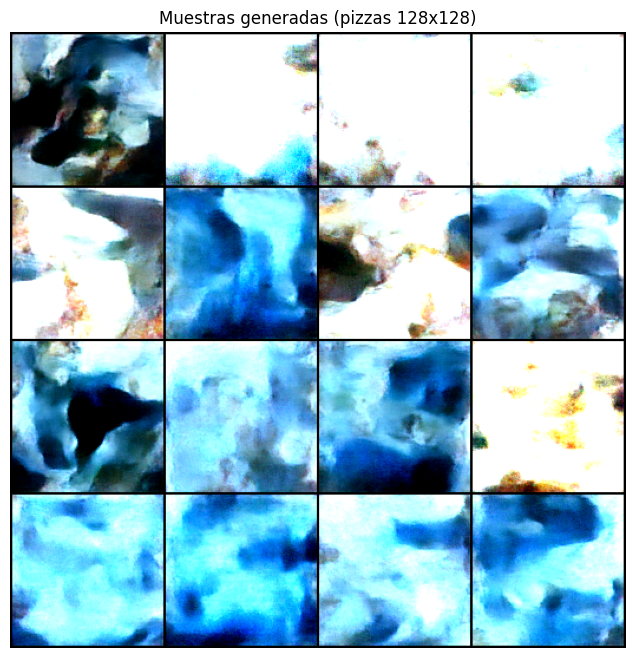

In [ ]:
# Sampling: generar imágenes desde ruido
@torch.no_grad()
def p_sample(model, x, t):
    b = x.shape[0]
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # predecimos el ruido
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)

    if (t == 0).all():
        return model_mean
    else:
        posterior_var_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_var_t) * noise

@torch.no_grad()
def p_sample_loop(model, shape, n_steps=T):
    img = torch.randn(shape, device=device)
    model.eval()
    for i in reversed(range(0, n_steps)):
        t = torch.full((shape[0],), i, device=device, dtype=torch.long)
        img = p_sample(model, img, t)
    return img

def sample_and_show(model, n=16):
    samples = p_sample_loop(model, (n, 3, 128, 128))
    grid = vutils.make_grid(samples, nrow=4, normalize=True, value_range=(-1,1))
    plt.figure(figsize=(8, 8)); plt.axis("off")
    plt.imshow(grid.permute(1,2,0).cpu())
    plt.title("Muestras generadas (pizzas 128x128)")
    plt.show()

sample_and_show(model, n=16)

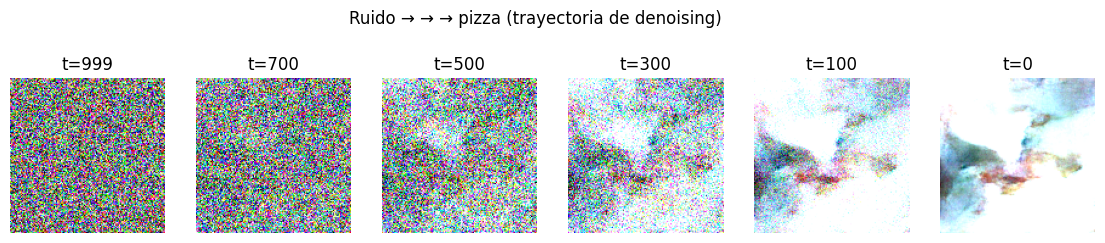

In [ ]:
# Visualizar trayectoria de denoising para 1 imagen
@torch.no_grad()
def denoise_trajectory(model, steps_to_show=(T-1, int(T*0.7), int(T*0.5), int(T*0.3), int(T*0.1), 0)):
    img = torch.randn((1, 3, 128, 128), device=device)  # ruido inicial RGB
    imgs = {}
    model.eval()
    for i in reversed(range(0, T)):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = p_sample(model, img, t)
        if i in steps_to_show:
            imgs[i] = img.detach().clone().cpu()
    return imgs

steps = (T-1, int(T*0.7), int(T*0.5), int(T*0.3), int(T*0.1), 0)
traj = denoise_trajectory(model, steps_to_show=steps)

fig, axs = plt.subplots(1, len(steps), figsize=(14, 3))
for j, s in enumerate(steps):
    # traj[s]: (1, 3, 128, 128) en [-1,1]
    img = traj[s][0]                  # (3, 128, 128)
    img = (img.permute(1, 2, 0) + 1) / 2  # -> [0,1] para imshow
    axs[j].imshow(img.clamp(0,1))
    axs[j].axis('off')
    axs[j].set_title(f"t={s}")
plt.suptitle("Ruido → → → pizza (trayectoria de denoising)")
plt.show()

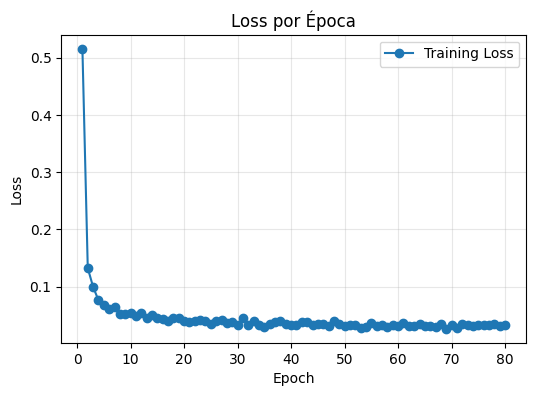

In [ ]:
# Visualizar funcion de perdida por epoch
plt.figure(figsize=(6,4))
plt.plot(range(1, len(loss_epoch_hist)+1), loss_epoch_hist, label="Training Loss", marker='o')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss por Época")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

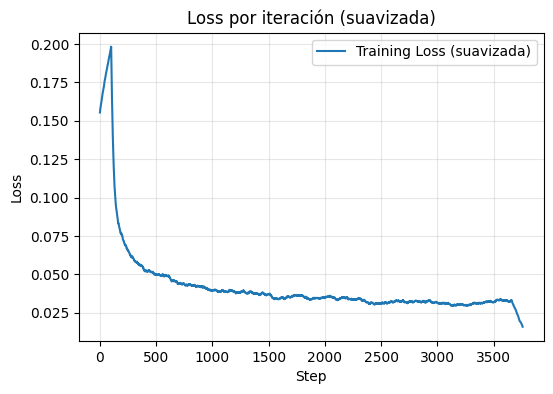

In [ ]:
# Mas suave
def smooth(y, k=5):
    k = max(1, k)
    filt = np.ones(k)/k
    return np.convolve(y, filt, mode='same')
plt.figure(figsize=(6,4))
plt.plot(smooth(loss_step_hist, k=200), label="Training Loss (suavizada)")
plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Loss por iteración (suavizada)")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()